In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage import transform

In [2]:

import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!pip install scikit-image


In [4]:
photo_size=224

In [5]:
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale= 1/255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=16,
        classes=['non_autistic','autistic']
    )
    return generator

In [6]:
train_data=prepare_dataset('./autistic-children-facial-data-set/train/')
validation_data = prepare_dataset('./autistic-children-facial-data-set/valid/')
test_data=prepare_dataset('./autistic-children-facial-data-set/test/')

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [7]:
validation_data.class_indices

{'non_autistic': 0, 'autistic': 1}

In [8]:
# example of tending the vgg16 model
def create_vgg_model():
    from keras.applications.vgg16 import VGG16
    from keras.models import Model
    from keras.layers import Dense
    from keras.layers import Flatten
    # load model without classifier layers
    model = VGG16(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer_idx in range(len(model.layers)):
        if layer_idx not in [1,2,3,15,16,17,18]:
            model.layers[layer_idx].trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(256, activation='relu')(flat1)
    output = Dense(95, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [9]:
vgg_model=create_vgg_model()
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgghist=vgg_model.fit(
    train_data,
    epochs=100,
    validation_data=validation_data 
    
)
vgg_model.save("vgg_model50.h5")

Epoch 1/100
159/159 [==============================] - 54s 267ms/step - loss: 0.7870 - accuracy: 0.5122 - val_loss: 0.7473 - val_accuracy: 0.5000
Epoch 2/100
159/159 [==============================] - 38s 237ms/step - loss: 0.6977 - accuracy: 0.6084 - val_loss: 0.6159 - val_accuracy: 0.7200
Epoch 3/100
159/159 [==============================] - 35s 222ms/step - loss: 0.6069 - accuracy: 0.6731 - val_loss: 0.6270 - val_accuracy: 0.6800
Epoch 4/100
159/159 [==============================] - 36s 225ms/step - loss: 0.5809 - accuracy: 0.6952 - val_loss: 0.6878 - val_accuracy: 0.5800
Epoch 5/100
159/159 [==============================] - 36s 227ms/step - loss: 0.5491 - accuracy: 0.7192 - val_loss: 0.6533 - val_accuracy: 0.6900
Epoch 6/100
159/159 [==============================] - 37s 230ms/step - loss: 0.5589 - accuracy: 0.7157 - val_loss: 0.7715 - val_accuracy: 0.6000
Epoch 7/100
159/159 [==============================] - 36s 225ms/step - loss: 0.5233 - accuracy: 0.7413 - val_loss: 0.6874 -

Epoch 57/100
159/159 [==============================] - 38s 239ms/step - loss: 0.2710 - accuracy: 0.8801 - val_loss: 0.4750 - val_accuracy: 0.8000
Epoch 58/100
159/159 [==============================] - 38s 235ms/step - loss: 0.2844 - accuracy: 0.8793 - val_loss: 0.5354 - val_accuracy: 0.7800
Epoch 59/100
159/159 [==============================] - 37s 232ms/step - loss: 0.2688 - accuracy: 0.8876 - val_loss: 0.5140 - val_accuracy: 0.7800
Epoch 60/100
159/159 [==============================] - 37s 234ms/step - loss: 0.2609 - accuracy: 0.8884 - val_loss: 0.4646 - val_accuracy: 0.7800
Epoch 61/100
159/159 [==============================] - 38s 235ms/step - loss: 0.2552 - accuracy: 0.8951 - val_loss: 0.5006 - val_accuracy: 0.8200
Epoch 62/100
159/159 [==============================] - 37s 230ms/step - loss: 0.2554 - accuracy: 0.8924 - val_loss: 0.5157 - val_accuracy: 0.7700
Epoch 63/100
159/159 [==============================] - 38s 238ms/step - loss: 0.2336 - accuracy: 0.9030 - val_loss: 0

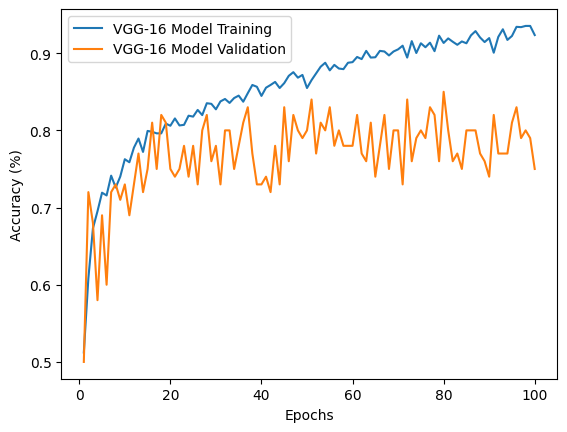

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(x, vgghist.history['accuracy'], label = "VGG-16 Model Training", linestyle="-")
plt.plot(x, vgghist.history['val_accuracy'], label = "VGG-16 Model Validation", linestyle="-")
plt.legend()
plt.show()

In [12]:
vgg_model.evaluate(train_data)

159/159 [==============================] - 35s 221ms/step - loss: 0.1468 - accuracy: 0.9405


[0.14680135250091553, 0.9404574036598206]

In [13]:
vgg_model.evaluate(test_data)

19/19 [==============================] - 6s 323ms/step - loss: 0.4757 - accuracy: 0.8233


[0.47570016980171204, 0.8233333230018616]

In [14]:
vgg_model.evaluate(validation_data)

7/7 [==============================] - 1s 183ms/step - loss: 0.9826 - accuracy: 0.7800


[0.9825626611709595, 0.7799999713897705]

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = vgg_model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

19/19 [==============================] - 5s 223ms/step
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       150
           1       0.52      0.53      0.52       150

    accuracy                           0.52       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.52      0.52      0.52       300



<Axes: >

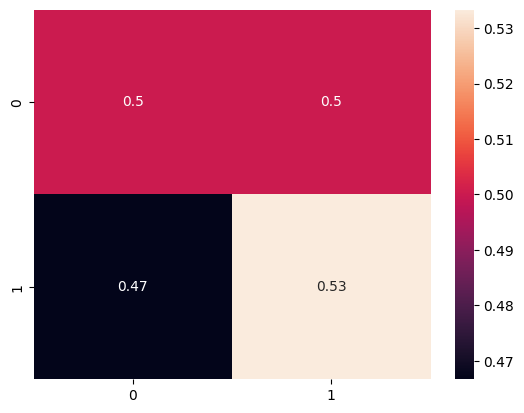

In [16]:
import seaborn as sns
cm = confusion_matrix(test_data.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

In [ ]:
#convnextbase end

In [17]:
def create_inception_model():
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    base_model = InceptionV3(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    # for layer_idx in range(len(pretrained_model.layers)):
    #     if layer_idx not in [1,2,3,305,306,307,308,309,310]:
    #         pretrained_model.layers[layer_idx].trainable = False
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras import layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Add a final sigmoid layer with 1 node for classification output
    x = layers.Dense(95, activation='softmax')(x)
    model = tf.keras.models.Model(base_model.input, x)
    model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
inception_model=create_inception_model()
inception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [19]:
incephist = inception_model.fit(
    train_data,
    epochs=100,
    validation_data=validation_data
)
inception_model.save("inception_model.h5")

Epoch 1/100
159/159 [==============================] - 45s 252ms/step - loss: 2.3751 - accuracy: 0.5966 - val_loss: 1.4481 - val_accuracy: 0.5700
Epoch 2/100
159/159 [==============================] - 38s 237ms/step - loss: 0.7460 - accuracy: 0.6719 - val_loss: 0.5966 - val_accuracy: 0.6900
Epoch 3/100
159/159 [==============================] - 38s 236ms/step - loss: 0.6171 - accuracy: 0.6960 - val_loss: 0.5509 - val_accuracy: 0.7800
Epoch 4/100
159/159 [==============================] - 37s 234ms/step - loss: 0.5961 - accuracy: 0.7129 - val_loss: 0.4898 - val_accuracy: 0.7700
Epoch 5/100
159/159 [==============================] - 37s 233ms/step - loss: 0.5786 - accuracy: 0.7212 - val_loss: 0.4952 - val_accuracy: 0.7800
Epoch 6/100
159/159 [==============================] - 37s 231ms/step - loss: 0.5653 - accuracy: 0.7263 - val_loss: 0.7040 - val_accuracy: 0.6800
Epoch 7/100
159/159 [==============================] - 38s 237ms/step - loss: 0.5483 - accuracy: 0.7315 - val_loss: 0.5682 -

Epoch 57/100
159/159 [==============================] - 37s 231ms/step - loss: 0.4307 - accuracy: 0.8084 - val_loss: 0.6232 - val_accuracy: 0.7100
Epoch 58/100
159/159 [==============================] - 37s 231ms/step - loss: 0.4472 - accuracy: 0.8084 - val_loss: 0.6510 - val_accuracy: 0.7000
Epoch 59/100
159/159 [==============================] - 38s 238ms/step - loss: 0.4299 - accuracy: 0.8072 - val_loss: 0.5262 - val_accuracy: 0.7800
Epoch 60/100
159/159 [==============================] - 36s 226ms/step - loss: 0.4326 - accuracy: 0.8080 - val_loss: 0.5272 - val_accuracy: 0.7300
Epoch 61/100
159/159 [==============================] - 38s 239ms/step - loss: 0.4265 - accuracy: 0.8091 - val_loss: 0.5904 - val_accuracy: 0.7400
Epoch 62/100
159/159 [==============================] - 36s 228ms/step - loss: 0.4329 - accuracy: 0.8123 - val_loss: 0.5723 - val_accuracy: 0.7100
Epoch 63/100
159/159 [==============================] - 37s 232ms/step - loss: 0.4511 - accuracy: 0.8084 - val_loss: 0

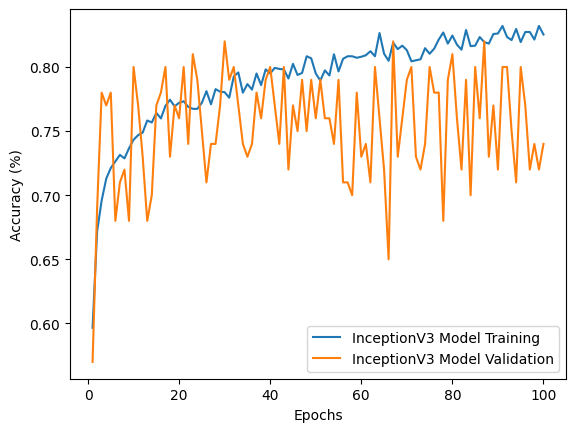

In [20]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(x, incephist.history['accuracy'], label = "InceptionV3 Model Training", linestyle="-")
plt.plot(x, incephist.history['val_accuracy'], label = "InceptionV3 Model Validation", linestyle="-")
plt.legend()
plt.show()

In [21]:
inception_model.evaluate(train_data)

159/159 [==============================] - 36s 222ms/step - loss: 0.3626 - accuracy: 0.8383


[0.36257582902908325, 0.8383280634880066]

In [22]:
inception_model.evaluate(test_data)

19/19 [==============================] - 8s 410ms/step - loss: 0.4953 - accuracy: 0.7800


[0.49532273411750793, 0.7799999713897705]

In [23]:
inception_model.evaluate(validation_data)

7/7 [==============================] - 2s 207ms/step - loss: 0.5761 - accuracy: 0.7200


[0.576099693775177, 0.7200000286102295]

In [24]:
from sklearn.metrics import classification_report

Y_pred = inception_model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

19/19 [==============================] - 6s 219ms/step
              precision    recall  f1-score   support

           0       0.46      0.43      0.45       150
           1       0.47      0.50      0.48       150

    accuracy                           0.47       300
   macro avg       0.47      0.47      0.47       300
weighted avg       0.47      0.47      0.47       300



<Axes: >

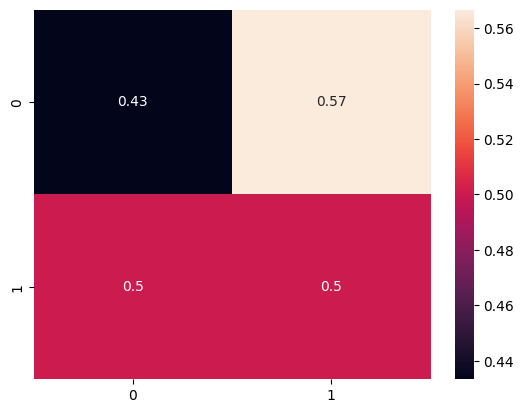

In [25]:
cm = confusion_matrix(test_data.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

In [ ]:
!pip install efficientnet

In [26]:
def use_efficient_net(model_type='B0'):
    from tensorflow.keras.optimizers import RMSprop
    from keras.models import Model
    import efficientnet.tfkeras as efn
    if model_type=='B0':
        efn_model = efn.EfficientNetB0(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    else:
        efn_model = efn.EfficientNetB7(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    for layer in efn_model.layers:
        layer.trainable = False
    #
    x = efn_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    # Add a final sigmoid layer with 1 node for classification output
    predictions = Dense(1, activation="sigmoid")(x)
    efficient_net = Model(efn_model.input,predictions)

    efficient_net.compile(RMSprop(learning_rate=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])
    return efficient_net
efficient_net=use_efficient_net('B0')
efficient_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                           

 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_s

 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_a

 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
          

In [27]:
effb0_history = efficient_net.fit(train_data, validation_data = validation_data, epochs = 100)
efficient_net.save("efficient_net_B0_model.h5")

Epoch 1/100
159/159 [==============================] - 45s 243ms/step - loss: 0.7194 - accuracy: 0.6380 - val_loss: 0.6248 - val_accuracy: 0.7000
Epoch 2/100
159/159 [==============================] - 36s 227ms/step - loss: 0.6298 - accuracy: 0.6952 - val_loss: 0.6463 - val_accuracy: 0.7100
Epoch 3/100
159/159 [==============================] - 37s 229ms/step - loss: 0.5796 - accuracy: 0.7153 - val_loss: 0.5360 - val_accuracy: 0.6800
Epoch 4/100
159/159 [==============================] - 37s 231ms/step - loss: 0.5945 - accuracy: 0.7287 - val_loss: 0.5501 - val_accuracy: 0.7400
Epoch 5/100
159/159 [==============================] - 37s 233ms/step - loss: 0.5610 - accuracy: 0.7362 - val_loss: 0.6580 - val_accuracy: 0.6800
Epoch 6/100
159/159 [==============================] - 36s 229ms/step - loss: 0.5625 - accuracy: 0.7315 - val_loss: 0.4963 - val_accuracy: 0.7200
Epoch 7/100
159/159 [==============================] - 37s 233ms/step - loss: 0.5277 - accuracy: 0.7484 - val_loss: 0.5127 -

Epoch 57/100
159/159 [==============================] - 36s 228ms/step - loss: 0.4209 - accuracy: 0.8340 - val_loss: 0.5111 - val_accuracy: 0.7400
Epoch 58/100
159/159 [==============================] - 36s 226ms/step - loss: 0.4261 - accuracy: 0.8166 - val_loss: 0.4557 - val_accuracy: 0.8000
Epoch 59/100
159/159 [==============================] - 36s 228ms/step - loss: 0.4179 - accuracy: 0.8218 - val_loss: 0.5283 - val_accuracy: 0.7600
Epoch 60/100
159/159 [==============================] - 36s 228ms/step - loss: 0.4169 - accuracy: 0.8139 - val_loss: 0.5281 - val_accuracy: 0.7500
Epoch 61/100
159/159 [==============================] - 37s 231ms/step - loss: 0.4499 - accuracy: 0.8222 - val_loss: 0.6066 - val_accuracy: 0.7300
Epoch 62/100
159/159 [==============================] - 37s 234ms/step - loss: 0.4024 - accuracy: 0.8273 - val_loss: 0.6052 - val_accuracy: 0.7900
Epoch 63/100
159/159 [==============================] - 36s 229ms/step - loss: 0.4137 - accuracy: 0.8190 - val_loss: 0

In [28]:
efficient_net.evaluate(train_data)

159/159 [==============================] - 36s 225ms/step - loss: 0.3294 - accuracy: 0.8632


[0.32941561937332153, 0.863170325756073]

In [29]:
efficient_net.evaluate(test_data)

19/19 [==============================] - 4s 223ms/step - loss: 0.5879 - accuracy: 0.8167


[0.5879061818122864, 0.8166666626930237]

In [30]:
efficient_net.evaluate(validation_data)

7/7 [==============================] - 2s 204ms/step - loss: 0.4769 - accuracy: 0.7600


[0.47693419456481934, 0.7599999904632568]

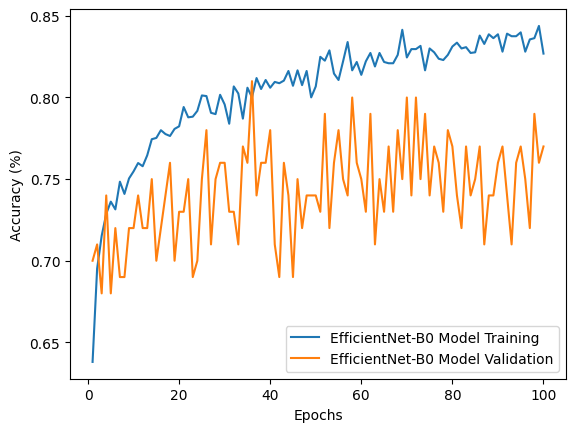

In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(x, effb0_history.history['accuracy'], label = "EfficientNet-B0 Model Training", linestyle="-")
plt.plot(x, effb0_history.history['val_accuracy'], label = "EfficientNet-B0 Model Validation", linestyle="-")
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import classification_report

Y_pred = efficient_net.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

19/19 [==============================] - 5s 212ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300



C:\Users\cl502_09\.conda\envs\tensorflowgpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cl502_09\.conda\envs\tensorflowgpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cl502_09\.conda\envs\tensorflowgpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

<Axes: >

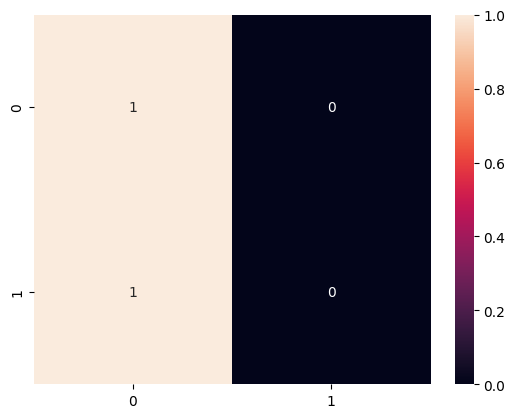

In [33]:
cm = confusion_matrix(test_data.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

In [34]:
def use_efficient_net(model_type='B0'):
    from tensorflow.keras.optimizers import RMSprop
    from keras.models import Model
    import efficientnet.tfkeras as efn
    if model_type=='B0':
        efn_model = efn.EfficientNetB0(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    else:
        efn_model = efn.EfficientNetB7(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet')
    for layer in efn_model.layers:
        layer.trainable = False
    #
    x = efn_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    # Add a final sigmoid layer with 1 node for classification output
    predictions = Dense(1, activation="sigmoid")(x)
    efficient_net = Model(efn_model.input,predictions)

    efficient_net.compile(RMSprop(learning_rate=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])
    return efficient_net
efficient_netb7=use_efficient_net('B7')
efficient_netb7.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256         ['stem_conv[0][0]']              
                                )                                                           

                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_s

 block2a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2a_se_reduce[0][0]']      
                                                                                                  
 block2a_se_excite (Multiply)   (None, 56, 56, 192)  0           ['block2a_activation[0][0]',     
                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 48)   9216        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_e

 block2c_drop (FixedDropout)    (None, 56, 56, 48)   0           ['block2c_project_bn[0][0]']     
                                                                                                  
 block2c_add (Add)              (None, 56, 56, 48)   0           ['block2c_drop[0][0]',           
                                                                  'block2b_add[0][0]']            
                                                                                                  
 block2d_expand_conv (Conv2D)   (None, 56, 56, 288)  13824       ['block2c_add[0][0]']            
                                                                                                  
 block2d_expand_bn (BatchNormal  (None, 56, 56, 288)  1152       ['block2d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2d_e

 block2f_expand_conv (Conv2D)   (None, 56, 56, 288)  13824       ['block2e_add[0][0]']            
                                                                                                  
 block2f_expand_bn (BatchNormal  (None, 56, 56, 288)  1152       ['block2f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2f_expand_activation (Act  (None, 56, 56, 288)  0          ['block2f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2f_dwconv (DepthwiseConv2  (None, 56, 56, 288)  2592       ['block2f_expand_activation[0][0]
 D)                                                              ']                               
          

 block3a_expand_activation (Act  (None, 56, 56, 288)  0          ['block3a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 288)  7200       ['block3a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 288)  1152       ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 288)  0          ['block3a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 480)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3c_se_reduce[0][0]']      
          

 block3e_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3e_se_squeeze[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3e_se_reduce[0][0]']      
                                                                                                  
 block3e_se_excite (Multiply)   (None, 28, 28, 480)  0           ['block3e_activation[0][0]',     
                                                                  'block3e_se_expand[0][0]']      
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 28, 28, 80)   38400       ['block3e_se_excite[0][0]']      
          

                                                                                                  
 block3g_se_excite (Multiply)   (None, 28, 28, 480)  0           ['block3g_activation[0][0]',     
                                                                  'block3g_se_expand[0][0]']      
                                                                                                  
 block3g_project_conv (Conv2D)  (None, 28, 28, 80)   38400       ['block3g_se_excite[0][0]']      
                                                                                                  
 block3g_project_bn (BatchNorma  (None, 28, 28, 80)  320         ['block3g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3g_drop (FixedDropout)    (None, 28, 28, 80)   0           ['block3g_project_bn[0][0]']     
          

                                                                                                  
 block4b_add (Add)              (None, 14, 14, 160)  0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 960)  0          ['block4c_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block4e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4e_expand_activation (Act  (None, 14, 14, 960)  0          ['block4e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4e_dwconv (DepthwiseConv2  (None, 14, 14, 960)  8640       ['block4e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4e_b

 ivation)                                                                                         
                                                                                                  
 block4g_dwconv (DepthwiseConv2  (None, 14, 14, 960)  8640       ['block4g_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4g_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block4g_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4g_activation (Activation  (None, 14, 14, 960)  0          ['block4g_bn[0][0]']             
 )                                                                                                
          

 block4i_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block4i_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4i_activation (Activation  (None, 14, 14, 960)  0          ['block4i_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4i_se_squeeze (GlobalAver  (None, 960)         0           ['block4i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4i_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4i_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 960)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 1344  0           ['block5c_activation[0][0]',     
                                )                                 'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 224)  301056      ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 224)  896        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

                                )                                 'block5e_se_expand[0][0]']      
                                                                                                  
 block5e_project_conv (Conv2D)  (None, 14, 14, 224)  301056      ['block5e_se_excite[0][0]']      
                                                                                                  
 block5e_project_bn (BatchNorma  (None, 14, 14, 224)  896        ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_drop (FixedDropout)    (None, 14, 14, 224)  0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 14, 14, 224)  0           ['block5e_drop[0][0]',           
          

                                                                                                  
 block5g_project_bn (BatchNorma  (None, 14, 14, 224)  896        ['block5g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5g_drop (FixedDropout)    (None, 14, 14, 224)  0           ['block5g_project_bn[0][0]']     
                                                                                                  
 block5g_add (Add)              (None, 14, 14, 224)  0           ['block5g_drop[0][0]',           
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 14, 14, 1344  301056      ['block5g_add[0][0]']            
          

                                                                                                  
 block5i_drop (FixedDropout)    (None, 14, 14, 224)  0           ['block5i_project_bn[0][0]']     
                                                                                                  
 block5i_add (Add)              (None, 14, 14, 224)  0           ['block5i_drop[0][0]',           
                                                                  'block5h_add[0][0]']            
                                                                                                  
 block5j_expand_conv (Conv2D)   (None, 14, 14, 1344  301056      ['block5i_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5j_expand_bn (BatchNormal  (None, 14, 14, 1344  5376       ['block5j_expand_conv[0][0]']    
 ization) 

 block6b_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6b_dwconv[0][0]']         
 )        

                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 2304)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_s

 )                                                                                                
                                                                                                  
 block6f_activation (Activation  (None, 7, 7, 2304)  0           ['block6f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2304)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_s

 block6h_se_squeeze (GlobalAver  (None, 2304)        0           ['block6h_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6h_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6h_se_squeeze[0][0]']     
                                                                                                  
 block6h_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6h_se_reshape[0][0]']     
                                                                                                  
 block6h_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6h_activation[0][0]',     
          

 block6j_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6j_se_reshape[0][0]']     
                                                                                                  
 block6j_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6j_se_reduce[0][0]']      
                                                                                                  
 block6j_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6j_activation[0][0]',     
                                                                  'block6j_se_expand[0][0]']      
                                                                                                  
 block6j_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6j_se_excite[0][0]']      
                                                                                                  
 block6j_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6j_project_conv[0][0]']   
 lization)

                                                                  'block6l_se_expand[0][0]']      
                                                                                                  
 block6l_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6l_se_excite[0][0]']      
                                                                                                  
 block6l_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6l_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6l_drop (FixedDropout)    (None, 7, 7, 384)    0           ['block6l_project_bn[0][0]']     
                                                                                                  
 block6l_add (Add)              (None, 7, 7, 384)    0           ['block6l_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 7, 7, 3840)   2457600     ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 7, 7, 3840)  15360       ['block7b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7b_expand_activation (Act  (None, 7, 7, 3840)  0           ['block7b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7b_d

 ization)                                                                                         
                                                                                                  
 block7d_expand_activation (Act  (None, 7, 7, 3840)  0           ['block7d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7d_dwconv (DepthwiseConv2  (None, 7, 7, 3840)  34560       ['block7d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7d_bn (BatchNormalization  (None, 7, 7, 3840)  15360       ['block7d_dwconv[0][0]']         
 )                                                                                                
          

In [35]:
effb7_history = efficient_netb7.fit(train_data, validation_data = validation_data, epochs = 100)
efficient_netb7.save("efficient_net_B7_model.h5")

Epoch 1/100
159/159 [==============================] - 65s 274ms/step - loss: 0.9650 - accuracy: 0.6124 - val_loss: 0.6457 - val_accuracy: 0.6900
Epoch 2/100
159/159 [==============================] - 38s 238ms/step - loss: 0.8074 - accuracy: 0.6471 - val_loss: 0.5940 - val_accuracy: 0.6700
Epoch 3/100
159/159 [==============================] - 39s 245ms/step - loss: 0.7530 - accuracy: 0.6597 - val_loss: 0.5691 - val_accuracy: 0.7100
Epoch 4/100
159/159 [==============================] - 39s 246ms/step - loss: 0.7104 - accuracy: 0.6790 - val_loss: 0.4804 - val_accuracy: 0.7600
Epoch 5/100
159/159 [==============================] - 40s 249ms/step - loss: 0.6929 - accuracy: 0.6960 - val_loss: 0.4785 - val_accuracy: 0.7500
Epoch 6/100
159/159 [==============================] - 38s 240ms/step - loss: 0.6408 - accuracy: 0.7066 - val_loss: 0.6114 - val_accuracy: 0.7400
Epoch 7/100
159/159 [==============================] - 38s 241ms/step - loss: 0.6656 - accuracy: 0.6944 - val_loss: 0.5426 -

Epoch 57/100
159/159 [==============================] - 40s 250ms/step - loss: 0.4895 - accuracy: 0.7776 - val_loss: 0.5536 - val_accuracy: 0.7600
Epoch 58/100
159/159 [==============================] - 38s 236ms/step - loss: 0.4900 - accuracy: 0.7847 - val_loss: 0.4747 - val_accuracy: 0.8200
Epoch 59/100
159/159 [==============================] - 39s 243ms/step - loss: 0.5069 - accuracy: 0.7804 - val_loss: 0.4602 - val_accuracy: 0.8000
Epoch 60/100
159/159 [==============================] - 39s 242ms/step - loss: 0.4933 - accuracy: 0.7823 - val_loss: 0.4709 - val_accuracy: 0.7500
Epoch 61/100
159/159 [==============================] - 40s 249ms/step - loss: 0.4889 - accuracy: 0.7815 - val_loss: 0.5013 - val_accuracy: 0.7700
Epoch 62/100
159/159 [==============================] - 38s 240ms/step - loss: 0.6368 - accuracy: 0.7815 - val_loss: 0.4983 - val_accuracy: 0.7900
Epoch 63/100
159/159 [==============================] - 39s 244ms/step - loss: 0.5345 - accuracy: 0.7725 - val_loss: 0

In [36]:
efficient_netb7.evaluate(train_data)

159/159 [==============================] - 37s 231ms/step - loss: 0.3847 - accuracy: 0.8214


[0.3846661150455475, 0.8213722109794617]

In [37]:
efficient_netb7.evaluate(test_data)

19/19 [==============================] - 5s 235ms/step - loss: 0.4235 - accuracy: 0.8033


[0.42346492409706116, 0.8033333420753479]

In [38]:
efficient_netb7.evaluate(validation_data)

7/7 [==============================] - 2s 210ms/step - loss: 0.4192 - accuracy: 0.7800


[0.4191735088825226, 0.7799999713897705]

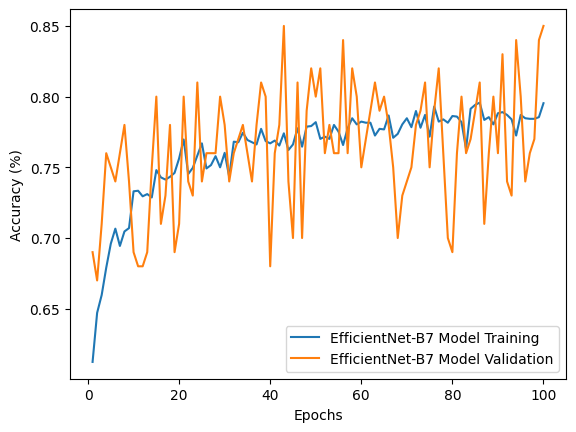

In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.plot(x, effb7_history.history['accuracy'], label = "EfficientNet-B7 Model Training", linestyle="-")
plt.plot(x, effb7_history.history['val_accuracy'], label = "EfficientNet-B7 Model Validation", linestyle="-")
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import classification_report

Y_pred = efficient_netb7.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

19/19 [==============================] - 10s 218ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300



C:\Users\cl502_09\.conda\envs\tensorflowgpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cl502_09\.conda\envs\tensorflowgpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cl502_09\.conda\envs\tensorflowgpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

<Axes: >

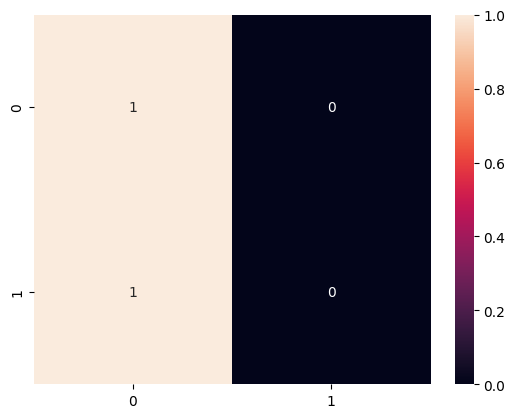

In [41]:
cm = confusion_matrix(test_data.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.plot(x, vgghist.history['accuracy'], label = "VGG-16 Model", linestyle="-")
plt.plot(x, incephist.history['accuracy'], label = "InceptionV3 Model", linestyle="-")
plt.plot(x, effb0_history.history['accuracy'], label = "EfficientNet-B0 Model", linestyle="-")
plt.plot(x, effb7_history.history['accuracy'], label = "EfficientNet-B7 Model", linestyle="-")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create data
x=[]
for i in range(1,101):
    x.append(i)

# plot lines
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.plot(x, vgghist.history['val_accuracy'], label = "VGG-16 Model", linestyle="-")
plt.plot(x, incephist.history['val_accuracy'], label = "InceptionV3 Model", linestyle="-")
plt.plot(x, effb0_history.history['val_accuracy'], label = "EfficientNet-B0 Model", linestyle="-")
plt.plot(x, effb7_history.history['accuracy'], label = "EfficientNet-B7 Model", linestyle="-")
plt.legend()
plt.show()

In [ ]:
from efficientnet.tfkeras import EfficientNetB0
from keras.models import load_model
efficientnet_b0_model= load_model('/kaggle/working/efficient_net_B0_model.h5')
efficientnet_b7_model= load_model('/kaggle/working/efficient_net_B7_model.h5')
vgg_model = load_model('/kaggle/working/vgg_model50.h5')
inception_v3_model = load_model('/kaggle/working/inception_model.h5')
#efficient_net_model.summary()

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
photo_size=224
def load_image_from_path(filename):
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32') / 255
    np_image = transform.resize(np_image, (photo_size, photo_size, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [ ]:
import os
mTestPath = "/kaggle/input/autistic-children-facial-data-set/test/autistic"
for test in os.listdir(mTestPath):
    print(test)
    img = load_image_from_path(os.path.join(mTestPath, test))
    res = vgg_model.predict(img).argmax()
    if(res==1):
        print("VGG-16\t\tAutistic")
    else:
        print("VGG-16\t\tNon-Autistic")
    res = inception_v3_model.predict(img).argmax()
    if(res==1):
        print("Inception-V3\tAutistic")
    else:
        print("Inception-V3\tNon-Autistic")
    res = efficientnet_b0_model.predict(img).argmax()
    if(res==1):
        print("Efficient-NetB0\tNon-Autistic")
    else:
        print("Efficient-NetB0\tAutistic")
    res = efficientnet_b7_model.predict(img).argmax()
    if(res==1):
        print("Efficient-NetB7\tNon-Autistic")
    else:
        print("Efficient-NetB7\tAutistic")

In [ ]:
import os
mTestPath = "/kaggle/input/autistic-children-facial-data-set/test/non_autistic"
for test in os.listdir(mTestPath):
    print(test)
    img = load_image_from_path(os.path.join(mTestPath, test))
    res = vgg_model.predict(img).argmax()
    if(res==1):
        print("VGG-16\t\tAutistic")
    else:
        print("VGG-16\t\tNon-Autistic")
    res = inception_v3_model.predict(img).argmax()
    if(res==1):
        print("Inception-V3\tAutistic")
    else:
        print("Inception-V3\tNon-Autistic")
    res = efficientnet_b0_model.predict(img).argmax()
    if(res==1):
        print("Efficient-NetB0\tAutistic")
    else:
        print("Efficient-NetB0\tNon-Autistic")
    res = efficientnet_b7_model.predict(img).argmax()
    if(res==1):
        print("Efficient-NetB7\tAutistic")
    else:
        print("Efficient-NetB7\tNon-Autistic")